In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import re
import plotly.express as px

In [2]:
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, mean_absolute_error, mean_squared_error, explained_variance_score, classification_report, recall_score, precision_score, f1_score, accuracy_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [136]:
from scikeras.wrappers import KerasClassifier
import tensorflow as tf
import keras_tuner as kt
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import visualkeras

## DATA - summary

### Import Hotel Dataset

In [4]:
path = "hotel_bookings.csv"

In [5]:
df = pd.read_csv(path)

In [6]:
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


## Get overall statistics for the data

### Data Description
    hotel (str) - Hotel (H1 = Resort Hotel or H2 = City Hotel)
    lead_time (int) - Number of days that elapsed between the entering date of the booking into the PMS and the arrival date
    arrival_date_year (int) - Year of arrival date
    arrival_date_month (str) - Month of arrival date
    arrival_date_week_number (int) - Week number of year for arrival date
    arrival_date_day_of_month (int) - Day of arrival date
    stays_in_weekend_nights (int) - Number of weekend nights (Saturday or Sunday) the guest stayed or booked to stay at the hotel
    stays_in_week_nights (int) - Number of week nights (Monday to Friday) the guest stayed or booked to stay at the hotel
    adults (int) - Number of adults
    children (float) - Number of children
    babies (int) - Number of babies
    meal (str) - Type of meal booked. Categories are presented in standard hospitality meal packages: (Undefined/SC = no meal package, BB = Bed & Breakfast, HB = Half board – breakfast and one other meal - usually dinner, FB = Full board – breakfast, lunch and dinner)
    country (str) - Country of origin. Categories are represented in the ISO 3155–3:2013 format
    market_segment (str) - Market segment designation (TA = Travel Agents, TO = Tour Operators)
    distribution_channel (str) - Booking distribution channel (TA = Travel Agents, TO = Tour Operators)
    is_repeated_guest (int) - Value indicating if the booking name was from a repeated guest (1) or not (0)
    previous_cancellations (int) - Number of previous bookings that were cancelled by the customer prior to the current booking
    previous_bookings_not_canceled (int) - Number of previous bookings not cancelled by the customer prior to the current booking
    reserved_room_type (str) - Code of room type reserved. Code is presented instead of designation for anonymity reasons
    assigned_room_type (str) - Code for the type of room assigned to the booking. Sometimes the assigned room type differs from the reserved room type due to hotel operation reasons (e.g. overbooking) or by customer request. Code is presented instead of designation for anonymity reasons
    booking_changes (int) - Number of changes/amendments made to the booking from the moment the booking was entered on the PMS until the moment of check-in or cancellation
    deposit_type (str) - Indication on if the customer made a deposit to guarantee the booking. This variable can assume three categories: (No Deposit = no deposit was made, Non Refund = a deposit was made in the value of the total stay cost, Refundable = a deposit was made with a value under the total cost of stay)
    agent (float) - ID of the travel agency that made the booking
    company (float) - ID of the company/entity that made the booking or responsible for paying the booking. ID is presented instead of designation for anonymity reasons
    days_in_waiting_list (int) - Number of days the booking was in the waiting list before it was confirmed to the customer
    customer_type (str) - Type of booking, assuming one of four categories: (Contract = when the booking has an allotment or other type of contract associated to it, Group = when the booking is associated to a group, Transient = when the booking is not part of a group or contract, and is not associated to other transient booking, Transient-party = when the booking is transient, but is associated to at least other transient booking
    adr (float) - Average Daily Rate as defined by dividing the sum of all lodging transactions by the total number of staying nights
    required_car_parking_spaces (int) - Number of car parking spaces required by the customer
    total_of_special_requests (int) - Number of special requests made by the customer (e.g. twin bed or high floor)
    reservation_status (str) - Reservation last status, assuming one of three categories: (Canceled = booking was canceled by the customer, Check-Out = customer has checked in but already departed, No-Show = customer did not check-in and did inform the hotel of the reason why)
    reservation_status_date (str) - Date at which the last status was set. This variable can be used in conjunction with the ReservationStatus to understand when was the booking canceled or when did the customer checked-out of the hotel


In [7]:
df.describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119386.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,103050.000000,6797.000000,119390.000000,119390.000000,119390.000000,119390.000000
mean,0.370416,104.011416,2016.156554,27.165173,15.798241,0.927599,2.500302,1.856403,0.103890,0.007949,0.031912,0.087118,0.137097,0.221124,86.693382,189.266735,2.321149,101.831122,0.062518,0.571363
std,0.482918,106.863097,0.707476,13.605138,8.780829,0.998613,1.908286,0.579261,0.398561,0.097436,0.175767,0.844336,1.497437,0.652306,110.774548,131.655015,17.594721,50.535790,0.245291,0.792798
min,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,6.000000,0.000000,-6.380000,0.000000,0.000000
25%,0.000000,18.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,62.000000,0.000000,69.290000,0.000000,0.000000
50%,0.000000,69.000000,2016.000000,28.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000,179.000000,0.000000,94.575000,0.000000,0.000000
75%,1.000000,160.000000,2017.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,229.000000,270.000000,0.000000,126.000000,0.000000,1.000000
max,1.000000,737.000000,2017.000000,53.000000,31.000000,19.000000,50.000000,55.000000,10.000000,10.000000,1.000000,26.000000,72.000000,21.000000,535.000000,543.000000,391.000000,5400.000000,8.000000,5.000000


#### Check for missing data

In [8]:
df.shape

(119390, 32)

In [9]:
df.isnull().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

In [10]:
# Our dependent variable will be is_canceled, so we would be interested to see which regressors are highly / low correlated 
# to it, so taht we can remove some of them
corr = df.corr()['is_canceled'].abs().sort_values(ascending=False)
corr

is_canceled                       1.000000
lead_time                         0.293123
total_of_special_requests         0.234658
required_car_parking_spaces       0.195498
booking_changes                   0.144381
previous_cancellations            0.110133
is_repeated_guest                 0.084793
agent                             0.083114
adults                            0.060017
previous_bookings_not_canceled    0.057358
days_in_waiting_list              0.054186
adr                               0.047557
babies                            0.032491
stays_in_week_nights              0.024765
company                           0.020642
arrival_date_year                 0.016660
arrival_date_week_number          0.008148
arrival_date_day_of_month         0.006130
children                          0.005048
stays_in_weekend_nights           0.001791
Name: is_canceled, dtype: float64

In [11]:
df.groupby("is_canceled")['hotel'].value_counts()

is_canceled  hotel       
0            City Hotel      46228
             Resort Hotel    28938
1            City Hotel      33102
             Resort Hotel    11122
Name: hotel, dtype: int64

In [12]:
# The idea is that if company or agent is 0, then the booking was not made through either of them
df['company'] = np.where(df['company'].isnull(),0,1)
df['agent'] = np.where(df['agent'].isnull(),0,1)

In [13]:
# These 3 columns cannot all be 0 at once (we cannot have 0 guests), so we can drop them
filter = (df.children==0) & (df.adults==0) & (df.babies==0)
df[filter]
df=df[~filter]

In [ ]:
# From previous research:

# to predict wheater or not a booking will be canceled, the number of booking changes is a possible source of leakage, 
# because this information can change over time.
# I will also not include days_in_waiting_list and arrival_date_year.

# The most important feature to exclude is the "reservation_status":

In [49]:
# This variables causes data leakeg
df.drop(['company'], axis=1,inplace=True)
df.drop(['stays_in_weekend_nights'], axis=1, inplace=True)
df.drop(['stays_in_week_nights'], axis=1, inplace=True)
df.drop(['deposit_type'], axis=1,inplace=True)
df.drop(['booking_changes'], axis=1, inplace=True)
df.drop(['country'], axis=1, inplace=True)
df.drop(['reserved_room_types'], axis=1,inplace=True)
df.drop(['reservation_status_date'], axis=1, inplace=True)
df.drop(['reservation_status'], axis=1, inplace=True)
df.drop(['arrival_date_year'], axis=1, inplace=True)
#  Another suggested varaible that was proved to cause disturbance in the results "assigned_room_type" will be dropped
df.drop(['assigned_room_type'], axis=1, inplace=True)

In [18]:
# Children and Babies seem to be relative unimportant to our task --> cancellation of a booking, so we can add them to 
# the adults in a combined family column:
df['family'] = df['adults'] + df['children'] + df['babies']
# # Therefore we can drop the adults, children & babies columns
df.drop(['adults'], axis=1, inplace=True)
df.drop(['children'], axis=1, inplace=True)
df.drop(['babies'], axis=1, inplace=True)

In [51]:
df.shape

(119210, 21)

In [21]:
# adr has 1 empty cell:
df['adr'] = df['adr'].fillna(value=df['adr'].mean())

In [50]:
# Empty cells are fixed
df.isnull().sum()

hotel                             0
is_canceled                       0
lead_time                         0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
meal                              0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
agent                             0
days_in_waiting_list              0
customer_type                     0
adr                               0
required_car_parking_spaces       0
total_of_special_requests         0
reservation_status_date           0
family                            0
dtype: int64

In [52]:
df.isna().sum()

hotel                             0
is_canceled                       0
lead_time                         0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
meal                              0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
agent                             0
days_in_waiting_list              0
customer_type                     0
adr                               0
required_car_parking_spaces       0
total_of_special_requests         0
reservation_status_date           0
family                            0
dtype: int64

In [24]:
df.dtypes

hotel                              object
is_canceled                         int64
lead_time                           int64
arrival_date_year                   int64
arrival_date_month                 object
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
meal                               object
market_segment                     object
distribution_channel               object
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
booking_changes                     int64
deposit_type                       object
agent                               int32
company                             int32
days_in_waiting_list                int64
customer_type                      object
adr                               float64
required_car_parking_spaces       

# Data Preprocessing

## Feature Selection

<AxesSubplot:>

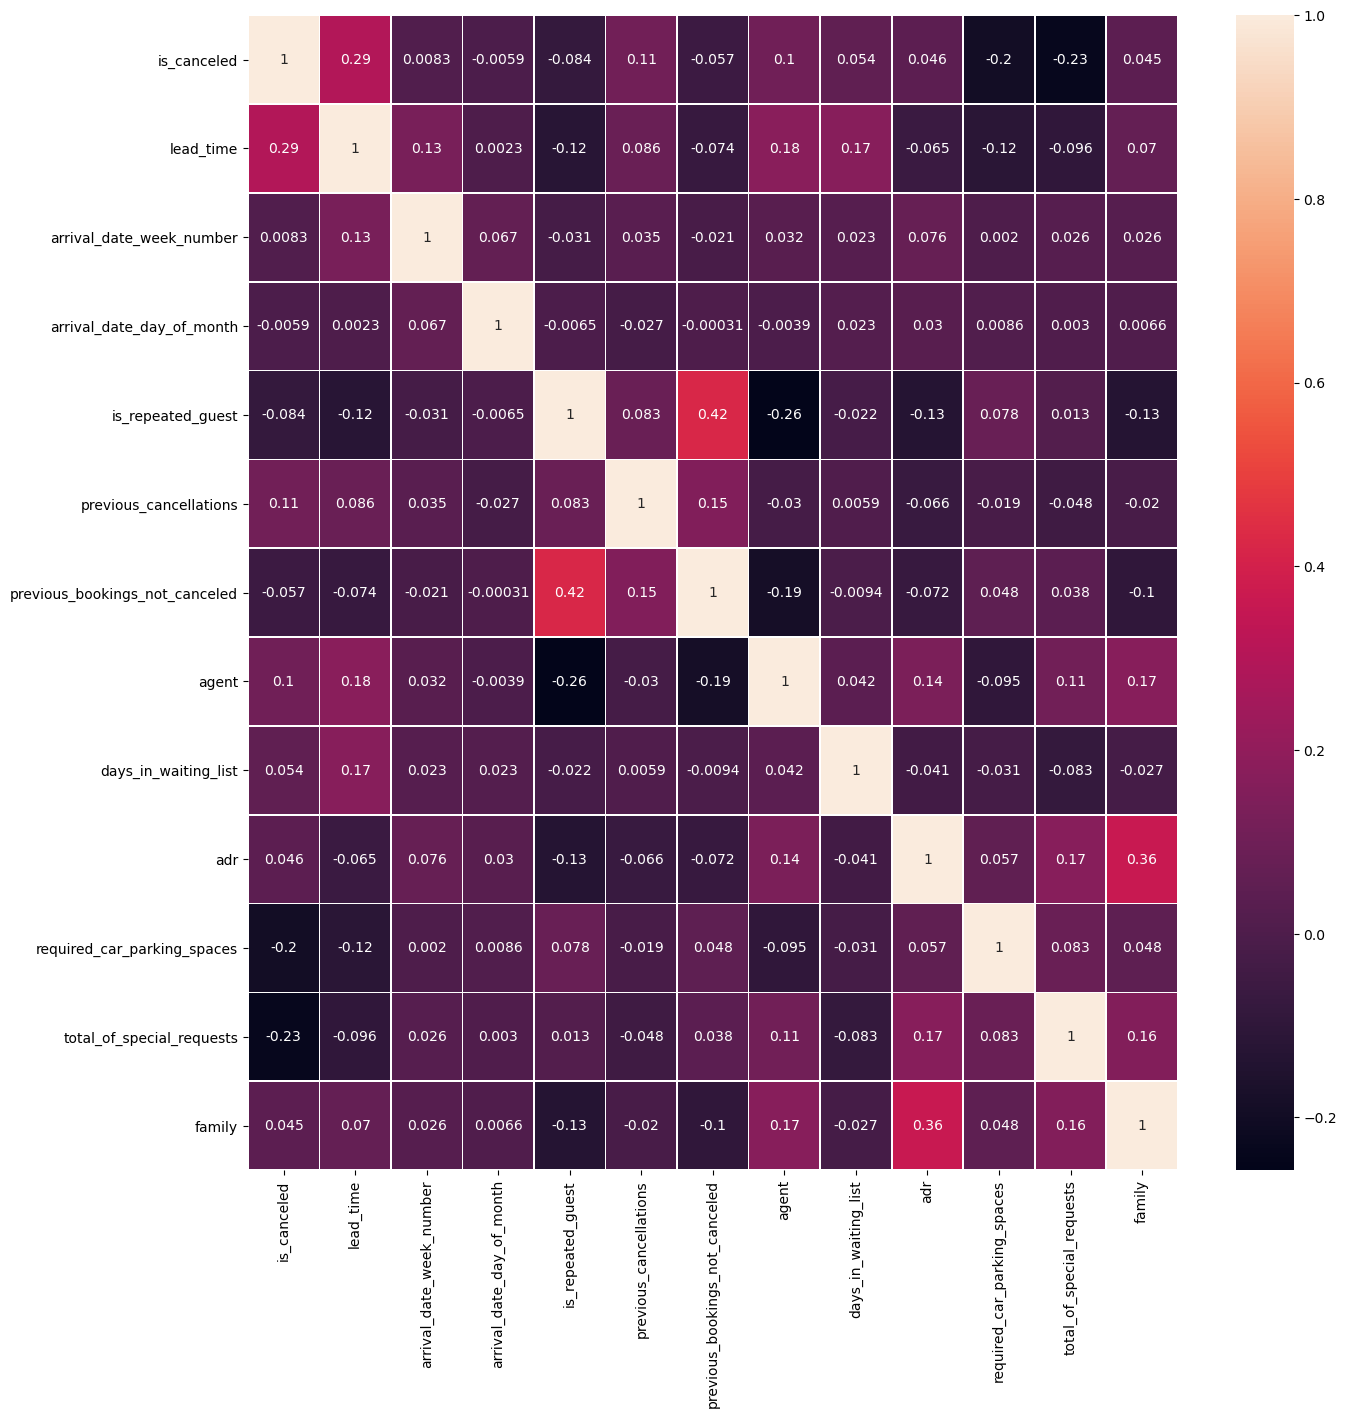

In [53]:
# Correlation Map
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(df.corr(), annot=True, linewidths=.5, ax=ax)

### Categorical data preprocessing

In [54]:
cat_cols = [col for col in df.columns if df[col].dtype==('object')]

In [55]:
df_cat = df[cat_cols]

In [56]:
df_cat.head()

,hotel,arrival_date_month,meal,market_segment,distribution_channel,reserved_room_type,customer_type,reservation_status_date
0,Resort Hotel,July,BB,Direct,Direct,C,Transient,2015-07-01
1,Resort Hotel,July,BB,Direct,Direct,C,Transient,2015-07-01
2,Resort Hotel,July,BB,Direct,Direct,A,Transient,2015-07-02
3,Resort Hotel,July,BB,Corporate,Corporate,A,Transient,2015-07-02
4,Resort Hotel,July,BB,Online TA,TA/TO,A,Transient,2015-07-03


In [58]:
label_enc = LabelEncoder()

In [59]:
df_cat_encoded = df_cat.apply(lambda x: label_enc.fit_transform(x))

### Numerical data preprocessing

In [61]:
df_num = df.drop(columns=cat_cols, axis=1)
num_cols = df_num.columns
df_num.head()

,is_canceled,lead_time,arrival_date_week_number,arrival_date_day_of_month,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,agent,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,family
0,0,342,27,1,0,0,0,0,0,0.0,0,0,2.0
1,0,737,27,1,0,0,0,0,0,0.0,0,0,2.0
2,0,7,27,1,0,0,0,0,0,75.0,0,0,1.0
3,0,13,27,1,0,0,0,1,0,75.0,0,0,1.0
4,0,14,27,1,0,0,0,1,0,98.0,0,1,2.0


In [62]:
# We need to normalize the data, so that we don't experience a great influence of the variables with higher variance on our data
df_num.var()

is_canceled                           0.233300
lead_time                         11422.361808
arrival_date_week_number            184.990111
arrival_date_day_of_month            77.107192
is_repeated_guest                     0.030507
previous_cancellations                0.713887
previous_bookings_not_canceled        2.244415
agent                                 0.117917
days_in_waiting_list                309.689671
adr                                2543.589039
required_car_parking_spaces           0.060201
total_of_special_requests             0.628652
family                                0.516783
dtype: float64

In [340]:
# # Normalize the numeric variables that have high variance
df_num['lead_time'] = np.log(df_num['lead_time'] + 1)
df_num['arrival_date_week_number'] = np.log(df_num['arrival_date_week_number'] + 1)
df_num['arrival_date_day_of_month'] = np.log(df_num['arrival_date_day_of_month'] + 1)
df_num['adr'] = np.log(df_num['adr'] + 1)

C:\Users\Asus\anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning:

invalid value encountered in log



### Training, validation and test data split:

In [64]:
# We will use this X for train / test
X = pd.concat([df_cat_encoded,df_num], axis=1)
X = X.drop('is_canceled', axis=1)
y = df['is_canceled']

In [65]:
# Split the sample into 60 % --> train, 20% ---> test, 20% --> validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.33, random_state=42, shuffle=True)

In [66]:
# Prepare Data in an array format:
X_train = np.array(X_train)
X_val = np.array(X_val)
y_train = np.array(y_train)
y_val = np.array(y_val)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [67]:
X_train.shape, X_test.shape

((59902, 19), (29803, 19))

# Logistic Regression

In [214]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)

acc_lr = accuracy_score(y_test, y_pred_lr)
conf = confusion_matrix(y_test, y_pred_lr)
clf_report = classification_report(y_test, y_pred_lr)

print(f"Accuracy Score of Logistic Regression is : {acc_lr}")
print(f"Confusion Matrix : \n{conf}")
print(f"Classification Report : \n{clf_report}")

C:\Users\Asus\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Accuracy Score of Logistic Regression is : 0.7386840250981445
Confusion Matrix : 
[[16324  2409]
 [ 5379  5691]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.75      0.87      0.81     18733
           1       0.70      0.51      0.59     11070

    accuracy                           0.74     29803
   macro avg       0.73      0.69      0.70     29803
weighted avg       0.73      0.74      0.73     29803



Text(50.72222222222221, 0.5, 'Actual')

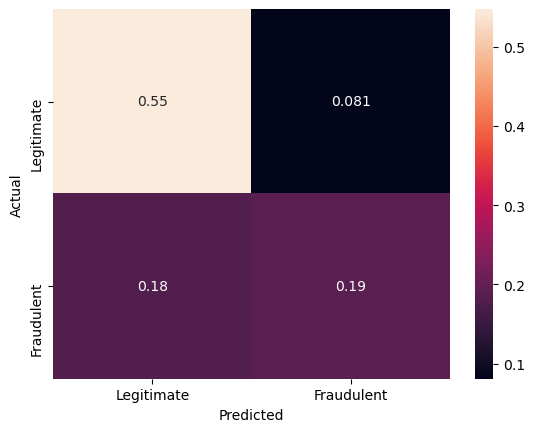

In [215]:
mat = confusion_matrix(y_test, y_pred_lr)
labels_conf_mat = ['Legitimate', 'Fraudulent']
sns.heatmap(mat/np.sum(mat),annot=True, xticklabels=labels_conf_mat, yticklabels=labels_conf_mat)
plt.xlabel('Predicted')
plt.ylabel('Actual')

# KNN - test

In [216]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

y_pred_knn = knn.predict(X_test)

acc_knn = accuracy_score(y_test, y_pred_knn)
conf = confusion_matrix(y_test, y_pred_knn)
clf_report = classification_report(y_test, y_pred_knn)

print(f"Accuracy Score of KNN is : {acc_knn}")
print(f"Confusion Matrix : \n{conf}")
print(f"Classification Report : \n{clf_report}")

Accuracy Score of KNN is : 0.756064825688689
Confusion Matrix : 
[[15733  3000]
 [ 4270  6800]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.79      0.84      0.81     18733
           1       0.69      0.61      0.65     11070

    accuracy                           0.76     29803
   macro avg       0.74      0.73      0.73     29803
weighted avg       0.75      0.76      0.75     29803



Text(50.72222222222221, 0.5, 'Actual')

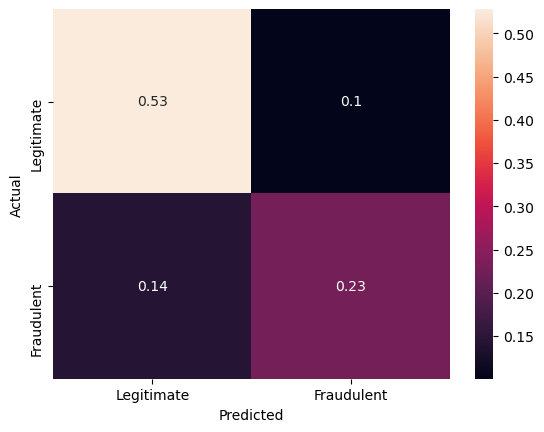

In [217]:
mat = confusion_matrix(y_test, y_pred_knn)
labels_conf_mat = ['Legitimate', 'Fraudulent']
sns.heatmap(mat/np.sum(mat),annot=True, xticklabels=labels_conf_mat, yticklabels=labels_conf_mat)
plt.xlabel('Predicted')
plt.ylabel('Actual')

## Decisiom Tree Classifier

In [218]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)

y_pred_dtc = dtc.predict(X_test)

acc_dtc = accuracy_score(y_test, y_pred_dtc)
conf = confusion_matrix(y_test, y_pred_dtc)
clf_report = classification_report(y_test, y_pred_dtc)

print(f"Accuracy Score of Decision Tree is : {acc_dtc}")
print(f"Confusion Matrix : \n{conf}")
print(f"Classification Report : \n{clf_report}")

Accuracy Score of Decision Tree is : 0.8082072274603228
Confusion Matrix : 
[[15813  2920]
 [ 2796  8274]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.85      0.84      0.85     18733
           1       0.74      0.75      0.74     11070

    accuracy                           0.81     29803
   macro avg       0.79      0.80      0.80     29803
weighted avg       0.81      0.81      0.81     29803



Text(50.72222222222221, 0.5, 'Actual')

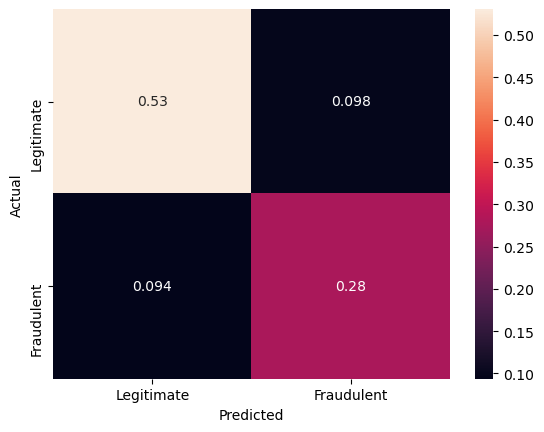

In [219]:
mat = confusion_matrix(y_test, y_pred_dtc)
labels_conf_mat = ['Legitimate', 'Fraudulent']
sns.heatmap(mat/np.sum(mat),annot=True, xticklabels=labels_conf_mat, yticklabels=labels_conf_mat)
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Artificial Neural Network
###### we initialize the number of columns, as they will be the input variables to the first layer

In [74]:
n_cols = X.shape[1]

#### Below we perform the training, and here we input the "best" parameters

In [187]:
model = Sequential()

#Input layer
model.add(Dense(n_cols, activation='relu', input_shape=(n_cols,)))

#First hidden layer
model.add(Dense(192, activation='relu',use_bias=True, bias_initializer='ones'))

#Dropout rate - normally 0.2 is suggested
model.add(Dropout(0.1))

#Second hidden layer
model.add(Dense(192, activation='relu',use_bias=True, bias_initializer='ones'))

#Dropout rate - normally 0.2 is suggested
model.add(Dropout(0.1))

model.add(Flatten())

#Output layer

model.add(Dense(1, activation='sigmoid'))

# optimizer 
adam = Adam(learning_rate=0.001)

#first apply the optimizing method adam, mean_squared_error is preferreable for regression  tasks)

model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

In [188]:
# Earlystopping will cut the training when the validation accuracy does not improve in N-consequtive epochs
early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=5, # how many epochs to wait before stopping
    restore_best_weights=True)

In [157]:
# #reconstruct the model identically to what we have trained in the Hyperparameter section at the bottom:
# reconstructed_model = tf.keras.models.load_model("ANN_hotel_model")

In [189]:
model.fit(X_train,y_train,
              validation_data=(X_val,y_val),
              callbacks=[early_stopping],
              batch_size=80,
              epochs=80)

Epoch 1/80
749/749 [==============================] - 14s 16ms/step - loss: 0.7240 - accuracy: 0.6476 - val_loss: 0.5799 - val_accuracy: 0.6867
Epoch 2/80
749/749 [==============================] - 12s 15ms/step - loss: 0.5670 - accuracy: 0.6972 - val_loss: 0.5326 - val_accuracy: 0.7187
Epoch 3/80
749/749 [==============================] - 11s 15ms/step - loss: 0.5269 - accuracy: 0.7321 - val_loss: 0.5034 - val_accuracy: 0.7444
Epoch 4/80
749/749 [==============================] - 11s 14ms/step - loss: 0.5076 - accuracy: 0.7474 - val_loss: 0.4993 - val_accuracy: 0.7551
Epoch 5/80
749/749 [==============================] - 11s 14ms/step - loss: 0.5004 - accuracy: 0.7528 - val_loss: 0.5140 - val_accuracy: 0.7398
Epoch 6/80
749/749 [==============================] - 11s 14ms/step - loss: 0.4931 - accuracy: 0.7560 - val_loss: 0.4821 - val_accuracy: 0.7605
Epoch 7/80
749/749 [==============================] - 11s 14ms/step - loss: 0.4890 - accuracy: 0.7567 - val_loss: 0.4949 - val_accuracy:

In [190]:
val_accuracy = np.mean(model.history.history['val_accuracy'])
print("\n%s: %.2f%%" % ('val_accuracy is', val_accuracy*100))


val_accuracy is: 78.54%


In [191]:
model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_80 (Dense)            (None, 19)                380       
                                                                 
 dense_81 (Dense)            (None, 192)               3840      
                                                                 
 dropout_40 (Dropout)        (None, 192)               0         
                                                                 
 dense_82 (Dense)            (None, 192)               37056     
                                                                 
 dropout_41 (Dropout)        (None, 192)               0         
                                                                 
 flatten_20 (Flatten)        (None, 192)               0         
                                                                 
 dense_83 (Dense)            (None, 1)               

In [192]:
loss_df = pd.DataFrame(model.history.history)
loss_df.columns

Index(['loss', 'accuracy', 'val_loss', 'val_accuracy'], dtype='object')

In [202]:
model_loss = loss_df['loss']
model_validation_loss = loss_df['val_loss']
model_accuracy = loss_df['accuracy']
model_validation_accuracy = loss_df['val_accuracy']
epochs = range(1, len(model_accuracy) + 1)

[]

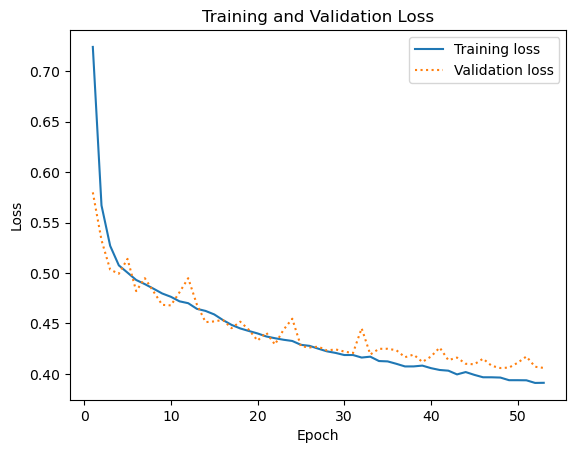

In [203]:
plt.plot(epochs, model_loss, '-', label='Training loss')
plt.plot(epochs, model_validation_loss, ':', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.savefig('Loss.png')
plt.plot()

[]

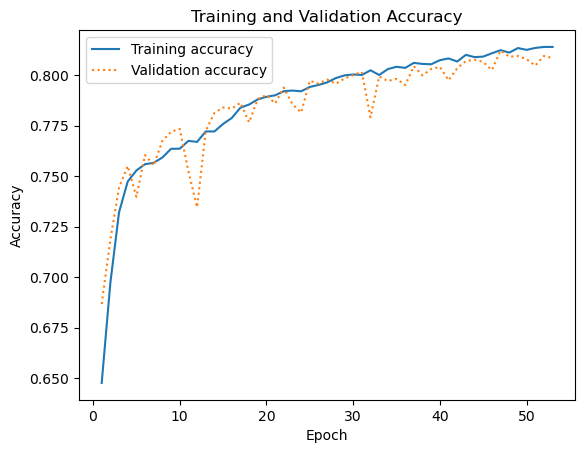

In [205]:
plt.plot(epochs, model_accuracy, '-', label='Training accuracy')
plt.plot(epochs, model_validation_accuracy, ':', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.savefig('accuracy.png')
plt.plot()

### Evaluation of the DATA

In [206]:
y_pred = model.predict(X_test)

932/932 [==============================] - 2s 2ms/step


In [207]:
# Turn the prediction variable into binary
y_pred = (y_pred > 0.5)

In [208]:
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))  
print('MSE:', metrics.mean_squared_error(y_test, y_pred))  
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('VarScore:',metrics.explained_variance_score(y_test,y_pred))

MAE: 0.1908868234741469
MSE: 0.1908868234741469
RMSE: 0.4369059663979732
VarScore: 0.19949786451369023


In [209]:
# Accuracy of the model
accuracy_score(y_test, y_pred)

0.8091131765258531

In [212]:
plt.figure(figsize = (12, 6))

epoch = range(1, len(model_accuracy) + 1)

loss = pd.DataFrame({'train_loss' : model_accuracy, 'val_loss' : model_validation_accuracy})

px.line(data_frame = loss, x = epoch, y = ['val_loss', 'train_loss'], title = 'Training and Validation Accuracy',
        template = 'plotly_dark')
plt.savefig("TrainValAccuracy")

<Figure size 1200x600 with 0 Axes>

#### Confustion MATRIX to vizualize performance of the model during testing

[]

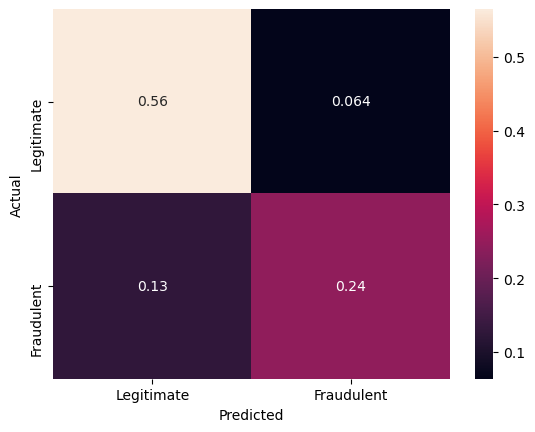

In [213]:
mat = confusion_matrix(y_test, y_pred)
labels_conf_mat = ['Legitimate', 'Fraudulent']
sns.heatmap(mat/np.sum(mat),annot=True, xticklabels=labels_conf_mat, yticklabels=labels_conf_mat)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('matrix.png')
plt.plot()

## GridSearch for the batch and epoch hyperparameters

In [178]:
batch = [20,30,50,80]
epochs = [20,30,40,50]
params_grid = dict(batch_size=batch, epochs=epochs)

In [171]:
kf = KFold(n_splits=10, shuffle=True,random_state=42)

In [173]:
ann_mod = KerasClassifier(build_fn=ann_model_func, verbose = 1)

In [179]:
grid = GridSearchCV(estimator = ann_mod,param_grid = params_grid,cv = kf,verbose = 1)
grid_res = grid.fit(X_train, y_train)

Fitting 10 folds for each of 16 candidates, totalling 160 fits
Epoch 1/20


C:\Users\Asus\anaconda3\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


2696/2696 [==============================] - 15s 5ms/step - loss: 0.6459 - accuracy: 0.6598
Epoch 2/20
2696/2696 [==============================] - 17s 6ms/step - loss: 0.5439 - accuracy: 0.7191
Epoch 3/20
2696/2696 [==============================] - 17s 6ms/step - loss: 0.5122 - accuracy: 0.7460
Epoch 4/20
2696/2696 [==============================] - 15s 6ms/step - loss: 0.4979 - accuracy: 0.7558
Epoch 5/20
2696/2696 [==============================] - 14s 5ms/step - loss: 0.4878 - accuracy: 0.7598
Epoch 6/20
2696/2696 [==============================] - 14s 5ms/step - loss: 0.4811 - accuracy: 0.7643
Epoch 7/20
2696/2696 [==============================] - 15s 6ms/step - loss: 0.4725 - accuracy: 0.7670
Epoch 8/20
2696/2696 [==============================] - 14s 5ms/step - loss: 0.4661 - accuracy: 0.7708
Epoch 9/20
2696/2696 [==============================] - 16s 6ms/step - loss: 0.4612 - accuracy: 0.7754
Epoch 10/20
2696/2696 [==============================] - 15s 6ms/step - loss: 0.4558

C:\Users\Asus\anaconda3\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


2696/2696 [==============================] - 14s 5ms/step - loss: 0.6436 - accuracy: 0.6618
Epoch 2/20
2696/2696 [==============================] - 13s 5ms/step - loss: 0.5388 - accuracy: 0.7271
Epoch 3/20
2696/2696 [==============================] - 17s 6ms/step - loss: 0.5110 - accuracy: 0.7479
Epoch 4/20
2696/2696 [==============================] - 15s 6ms/step - loss: 0.4978 - accuracy: 0.7549
Epoch 5/20
2696/2696 [==============================] - 13s 5ms/step - loss: 0.4855 - accuracy: 0.7644
Epoch 6/20
2696/2696 [==============================] - 14s 5ms/step - loss: 0.4753 - accuracy: 0.7698
Epoch 7/20
2696/2696 [==============================] - 16s 6ms/step - loss: 0.4636 - accuracy: 0.7767
Epoch 8/20
2696/2696 [==============================] - 14s 5ms/step - loss: 0.4589 - accuracy: 0.7801
Epoch 9/20
2696/2696 [==============================] - 16s 6ms/step - loss: 0.4520 - accuracy: 0.7824
Epoch 10/20
2696/2696 [==============================] - 19s 7ms/step - loss: 0.4486

C:\Users\Asus\anaconda3\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
2696/2696 [==============================] - 15s 5ms/step - loss: 0.6391 - accuracy: 0.6610
Epoch 2/20
2696/2696 [==============================] - 14s 5ms/step - loss: 0.5387 - accuracy: 0.7243
Epoch 3/20
2696/2696 [==============================] - 13s 5ms/step - loss: 0.5117 - accuracy: 0.7456
Epoch 4/20
2696/2696 [==============================] - 14s 5ms/step - loss: 0.5024 - accuracy: 0.7512
Epoch 5/20
2696/2696 [==============================] - 14s 5ms/step - loss: 0.4934 - accuracy: 0.7548
Epoch 6/20
2696/2696 [==============================] - 14s 5ms/step - loss: 0.4849 - accuracy: 0.7607
Epoch 7/20
2696/2696 [==============================] - 14s 5ms/step - loss: 0.4780 - accuracy: 0.7641
Epoch 8/20
2696/2696 [==============================] - 14s 5ms/step - loss: 0.4711 - accuracy: 0.7682
Epoch 9/20
2696/2696 [==============================] - 14s 5ms/step - loss: 0.4619 - accuracy: 0.7751
Epoch 10/20
2696/2696 [==============================] - 14s 5ms/step - l

C:\Users\Asus\anaconda3\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/20
2696/2696 [==============================] - 24s 7ms/step - loss: 0.6651 - accuracy: 0.6569
Epoch 2/20
2696/2696 [==============================] - 17s 6ms/step - loss: 0.5596 - accuracy: 0.7074
Epoch 3/20
2696/2696 [==============================] - 14s 5ms/step - loss: 0.5192 - accuracy: 0.7395
Epoch 4/20
2696/2696 [==============================] - 15s 6ms/step - loss: 0.5038 - accuracy: 0.7503
Epoch 5/20
2696/2696 [==============================] - 17s 6ms/step - loss: 0.4973 - accuracy: 0.7549
Epoch 6/20
2696/2696 [==============================] - 22s 8ms/step - loss: 0.4893 - accuracy: 0.7589
Epoch 7/20
2696/2696 [==============================] - 17s 6ms/step - loss: 0.4848 - accuracy: 0.7627
Epoch 8/20
2696/2696 [==============================] - 18s 7ms/step - loss: 0.4820 - accuracy: 0.7632
Epoch 9/20
2696/2696 [==============================] - 19s 7ms/step - loss: 0.4757 - accuracy: 0.7686
Epoch 10/20
2696/2696 [==============================] - 15s 6ms/step - l

C:\Users\Asus\anaconda3\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


2696/2696 [==============================] - 17s 6ms/step - loss: 0.6346 - accuracy: 0.6632
Epoch 2/20
2696/2696 [==============================] - 15s 6ms/step - loss: 0.5331 - accuracy: 0.7318
Epoch 3/20
2696/2696 [==============================] - 14s 5ms/step - loss: 0.5008 - accuracy: 0.7526
Epoch 4/20
2696/2696 [==============================] - 14s 5ms/step - loss: 0.4856 - accuracy: 0.7600
Epoch 5/20
2696/2696 [==============================] - 19s 7ms/step - loss: 0.4743 - accuracy: 0.7688
Epoch 6/20
2696/2696 [==============================] - 13s 5ms/step - loss: 0.4656 - accuracy: 0.7743
Epoch 7/20
2696/2696 [==============================] - 17s 6ms/step - loss: 0.4585 - accuracy: 0.7782
Epoch 8/20
2696/2696 [==============================] - 15s 5ms/step - loss: 0.4524 - accuracy: 0.7807
Epoch 9/20
2696/2696 [==============================] - 17s 6ms/step - loss: 0.4497 - accuracy: 0.7829
Epoch 10/20
2696/2696 [==============================] - 16s 6ms/step - loss: 0.4443

C:\Users\Asus\anaconda3\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


2696/2696 [==============================] - 17s 6ms/step - loss: 0.6297 - accuracy: 0.6664
Epoch 2/20
2696/2696 [==============================] - 19s 7ms/step - loss: 0.5315 - accuracy: 0.7344
Epoch 3/20
2696/2696 [==============================] - 17s 6ms/step - loss: 0.5036 - accuracy: 0.7533
Epoch 4/20
2696/2696 [==============================] - 16s 6ms/step - loss: 0.4901 - accuracy: 0.7594
Epoch 5/20
2696/2696 [==============================] - 17s 6ms/step - loss: 0.4800 - accuracy: 0.7654
Epoch 6/20
2696/2696 [==============================] - 16s 6ms/step - loss: 0.4726 - accuracy: 0.7679
Epoch 7/20
2696/2696 [==============================] - 22s 8ms/step - loss: 0.4640 - accuracy: 0.7757
Epoch 8/20
2696/2696 [==============================] - 15s 5ms/step - loss: 0.4614 - accuracy: 0.7771
Epoch 9/20
2696/2696 [==============================] - 15s 6ms/step - loss: 0.4544 - accuracy: 0.7806
Epoch 10/20
2696/2696 [==============================] - 15s 6ms/step - loss: 0.4521

C:\Users\Asus\anaconda3\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


2696/2696 [==============================] - 17s 6ms/step - loss: 0.6748 - accuracy: 0.6562
Epoch 2/20
2696/2696 [==============================] - 17s 6ms/step - loss: 0.5604 - accuracy: 0.7057
Epoch 3/20
2696/2696 [==============================] - 16s 6ms/step - loss: 0.5200 - accuracy: 0.7387
Epoch 4/20
2696/2696 [==============================] - 15s 6ms/step - loss: 0.5053 - accuracy: 0.7504
Epoch 5/20
2696/2696 [==============================] - 15s 6ms/step - loss: 0.4978 - accuracy: 0.7541
Epoch 6/20
2696/2696 [==============================] - 16s 6ms/step - loss: 0.4885 - accuracy: 0.7580
Epoch 7/20
2696/2696 [==============================] - 15s 5ms/step - loss: 0.4795 - accuracy: 0.7618
Epoch 8/20
2696/2696 [==============================] - 16s 6ms/step - loss: 0.4719 - accuracy: 0.7701
Epoch 9/20
2696/2696 [==============================] - 15s 6ms/step - loss: 0.4654 - accuracy: 0.7731
Epoch 10/20
2696/2696 [==============================] - 15s 6ms/step - loss: 0.4591

C:\Users\Asus\anaconda3\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


2696/2696 [==============================] - 16s 6ms/step - loss: 0.6516 - accuracy: 0.6599
Epoch 2/20
2696/2696 [==============================] - 17s 6ms/step - loss: 0.5391 - accuracy: 0.7271
Epoch 3/20
2696/2696 [==============================] - 16s 6ms/step - loss: 0.5090 - accuracy: 0.7476
Epoch 4/20
2696/2696 [==============================] - 15s 5ms/step - loss: 0.4968 - accuracy: 0.7563
Epoch 5/20
2696/2696 [==============================] - 15s 6ms/step - loss: 0.4840 - accuracy: 0.7628
Epoch 6/20
2696/2696 [==============================] - 17s 6ms/step - loss: 0.4697 - accuracy: 0.7730
Epoch 7/20
2696/2696 [==============================] - 16s 6ms/step - loss: 0.4624 - accuracy: 0.7781
Epoch 8/20
2696/2696 [==============================] - 17s 6ms/step - loss: 0.4588 - accuracy: 0.7802
Epoch 9/20
2696/2696 [==============================] - 15s 5ms/step - loss: 0.4547 - accuracy: 0.7827
Epoch 10/20
2696/2696 [==============================] - 16s 6ms/step - loss: 0.4506

C:\Users\Asus\anaconda3\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


2696/2696 [==============================] - 18s 6ms/step - loss: 0.6464 - accuracy: 0.6647
Epoch 2/20
2696/2696 [==============================] - 16s 6ms/step - loss: 0.5402 - accuracy: 0.7240
Epoch 3/20
2696/2696 [==============================] - 16s 6ms/step - loss: 0.5057 - accuracy: 0.7511
Epoch 4/20
2696/2696 [==============================] - 16s 6ms/step - loss: 0.4890 - accuracy: 0.7603
Epoch 5/20
2696/2696 [==============================] - 17s 6ms/step - loss: 0.4752 - accuracy: 0.7692
Epoch 6/20
2696/2696 [==============================] - 16s 6ms/step - loss: 0.4648 - accuracy: 0.7747
Epoch 7/20
2696/2696 [==============================] - 16s 6ms/step - loss: 0.4567 - accuracy: 0.7805
Epoch 8/20
2696/2696 [==============================] - 17s 6ms/step - loss: 0.4515 - accuracy: 0.7838
Epoch 9/20
2696/2696 [==============================] - 17s 6ms/step - loss: 0.4488 - accuracy: 0.7850
Epoch 10/20
2696/2696 [==============================] - 14s 5ms/step - loss: 0.4441

C:\Users\Asus\anaconda3\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


2696/2696 [==============================] - 17s 6ms/step - loss: 0.6659 - accuracy: 0.6607
Epoch 2/20
2696/2696 [==============================] - 18s 6ms/step - loss: 0.5408 - accuracy: 0.7240
Epoch 3/20
2696/2696 [==============================] - 14s 5ms/step - loss: 0.5127 - accuracy: 0.7459
Epoch 4/20
2696/2696 [==============================] - 14s 5ms/step - loss: 0.5005 - accuracy: 0.7527
Epoch 5/20
2696/2696 [==============================] - 14s 5ms/step - loss: 0.4916 - accuracy: 0.7589
Epoch 6/20
2696/2696 [==============================] - 14s 5ms/step - loss: 0.4834 - accuracy: 0.7613
Epoch 7/20
2696/2696 [==============================] - 14s 5ms/step - loss: 0.4724 - accuracy: 0.7680
Epoch 8/20
2696/2696 [==============================] - 14s 5ms/step - loss: 0.4650 - accuracy: 0.7750
Epoch 9/20
2696/2696 [==============================] - 14s 5ms/step - loss: 0.4593 - accuracy: 0.7768
Epoch 10/20
2696/2696 [==============================] - 14s 5ms/step - loss: 0.4549

C:\Users\Asus\anaconda3\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


Epoch 1/30
2696/2696 [==============================] - 24s 8ms/step - loss: 0.6523 - accuracy: 0.6606
Epoch 2/30
2696/2696 [==============================] - 14s 5ms/step - loss: 0.5446 - accuracy: 0.7197
Epoch 3/30
2696/2696 [==============================] - 13s 5ms/step - loss: 0.5103 - accuracy: 0.7475
Epoch 4/30
2696/2696 [==============================] - 14s 5ms/step - loss: 0.4970 - accuracy: 0.7545
Epoch 5/30
2696/2696 [==============================] - 13s 5ms/step - loss: 0.4905 - accuracy: 0.7585
Epoch 6/30
2696/2696 [==============================] - 13s 5ms/step - loss: 0.4848 - accuracy: 0.7626
Epoch 7/30
2696/2696 [==============================] - 13s 5ms/step - loss: 0.4783 - accuracy: 0.7648
Epoch 8/30
2696/2696 [==============================] - 13s 5ms/step - loss: 0.4736 - accuracy: 0.7670
Epoch 9/30
2696/2696 [==============================] - 13s 5ms/step - loss: 0.4672 - accuracy: 0.7720
Epoch 10/30
2696/2696 [==============================] - 13s 5ms/step - l

C:\Users\Asus\anaconda3\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


2696/2696 [==============================] - 14s 5ms/step - loss: 0.6701 - accuracy: 0.6522
Epoch 2/30
2696/2696 [==============================] - 14s 5ms/step - loss: 0.5468 - accuracy: 0.7168
Epoch 3/30
2696/2696 [==============================] - 14s 5ms/step - loss: 0.5105 - accuracy: 0.7490
Epoch 4/30
2696/2696 [==============================] - 13s 5ms/step - loss: 0.4980 - accuracy: 0.7558
Epoch 5/30
2696/2696 [==============================] - 13s 5ms/step - loss: 0.4891 - accuracy: 0.7587
Epoch 6/30
2696/2696 [==============================] - 13s 5ms/step - loss: 0.4795 - accuracy: 0.7652
Epoch 7/30
2696/2696 [==============================] - 13s 5ms/step - loss: 0.4676 - accuracy: 0.7732
Epoch 8/30
2696/2696 [==============================] - 14s 5ms/step - loss: 0.4604 - accuracy: 0.7792
Epoch 9/30
2696/2696 [==============================] - 13s 5ms/step - loss: 0.4566 - accuracy: 0.7804
Epoch 10/30
2696/2696 [==============================] - 13s 5ms/step - loss: 0.4524

C:\Users\Asus\anaconda3\lib\site-packages\scikeras\wrappers.py:301: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(


2696/2696 [==============================] - 23s 6ms/step - loss: 0.6329 - accuracy: 0.6584
Epoch 2/30
2696/2696 [==============================] - 18s 7ms/step - loss: 0.5515 - accuracy: 0.7118
Epoch 3/30
2696/2696 [==============================] - 19s 7ms/step - loss: 0.5135 - accuracy: 0.7445
Epoch 4/30
2696/2696 [==============================] - 19s 7ms/step - loss: 0.5006 - accuracy: 0.7519
Epoch 5/30
2696/2696 [==============================] - 17s 6ms/step - loss: 0.4915 - accuracy: 0.7581
Epoch 6/30
2696/2696 [==============================] - 20s 7ms/step - loss: 0.4862 - accuracy: 0.7602
Epoch 7/30
2696/2696 [==============================] - 29s 11ms/step - loss: 0.4827 - accuracy: 0.7621
Epoch 8/30
2696/2696 [==============================] - 56s 21ms/step - loss: 0.4785 - accuracy: 0.7635
Epoch 9/30
2696/2696 [==============================] - 38s 14ms/step - loss: 0.4720 - accuracy: 0.7701
Epoch 10/30
 929/2696 [=========>....................] - ETA: 12s - loss: 0.4707 

KeyboardInterrupt: 

## Hyperparameter tuning

In [103]:
def build_model(hp):
    
    """
    This function build an ANN model.
    
    Param: hp: Hyperparameters that will be optimized
    
    The hyperparameters that will be optimized are:
    the number of layers,
    the number of neurons per layer,
    the dropout rate,
    the type of activation function,
    the learning rate.
    
    The function allows for different values for each parameter, constructs the ANN model using the Keras library and tensorflow.
    
    The function uses the ADAM optimizer and the Binary Crossentropy loss function
    
    Return: model ---> the function returns the best architecture based on its hyperparameters.    
    """
    
    
    dnn_layers_ss = [1,2]   # Number of layers
    dnn_units_min, dnn_units_max, step = 64, 256, 32 # number of neurons per layer
    dropout_ss = [0.1,0.2,0.3,0.5]  # dropout rate
    lr_ss = [0.001,0.0001] # learning rate
    active_func_ss = ['relu','tanh'] #activation function
       
    # Combination of randomly picked hyperparameters:
    active_func = hp.Choice('activation', active_func_ss) # choose an activation function
    
    lr = hp.Choice('learning_rate', lr_ss) #chooses a learning rate within the given range
    
    dropout = hp.Choice('dropout', dropout_ss) # choose a dropout rate
    
    inputs = tf.keras.Input(shape=(n_cols,)) #creates an input layer with a shape, equal to number of columns. The idea is to have as much neurons in the input layer as variables
        
    flatten_layer = Flatten()(inputs) # Creates a 1-D array for the input layer
    
    # create hidden layers
    dnn_units = hp.Int(f"0_units", min_value=dnn_units_min, max_value=dnn_units_max, step=step) # chooses a number of neurons within the range for the hidden layers
    dense = tf.keras.layers.Dense(units=dnn_units, activation=active_func, use_bias=True, bias_initializer='ones')(flatten_layer) # creates layer with the specific number of neurons selected in the line above + sets the chosen activation function

    
    # Creating the architecture based on the upper randomly selected hyperparameters
    # loops through the number of chosen layers
    for layer_i in range(hp.Choice("n_layers", dnn_layers_ss)):
        # chooses a number of layers with the selected number of neurons from the previous line
        dnn_units = hp.Int(f"{layer_i}_units", min_value=dnn_units_min, max_value=dnn_units_max, step=step)
        dense = Dense(units=dnn_units, activation=active_func, use_bias=True, bias_initializer='ones')(dense)   
        # if the model performs better with a Dropout, it will add one after the hidden layer
        if hp.Boolean("dropout"):
            dense = Dropout(rate=dropout)(dense)
    
    # sets the output layer with 1 neuron since the function will estimate a regression, and will produce one value
    outputs = tf.keras.layers.Dense(units=1, activation='sigmoid')(dense)
    # build the model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    # set optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
        
    # compile the model with chosen optimizer, loss function and metrics
    model.compile(optimizer=optimizer,
                 loss="binary_crossentropy",
                 metrics=['accuracy'])
    
    return model

In [105]:
#RandomSearch will take a combination of the hyperparameters that will be test, but not all possible ones. 
tuner1 = kt.RandomSearch(build_model, # the created ANN model
                        objective='val_accuracy',  # the metrics we are interested to observe
                        max_trials=100, # how many times we train the model
                        # The purpose of having multiple executions per trial is to reduce results variance and therefore be able to more accurately assess the performance of a model.
                        executions_per_trial=1, # we set 1 different weight initializations for each hyperparameter combination ,which basically trains the same model but achieves different results
                        overwrite=True, # overwrite file in same directory
                        project_name='ANN_HOTELS_FINAL',
                        directory='C:/Users/Asus/Data Case')

In [106]:
# EarlyStopping will allow the training cycle to end if there is no improvement in accuracy
early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=5, # how many epochs to wait before stopping
    restore_best_weights=True)

In [107]:
# search is a function that will perform the model N-times (number of epochs) and will apply the combinations from the random search
# to find the best Hyperparameters

tuner1.search(X_train,y_train, epochs=40,batch_size=80, validation_data=(X_val,y_val), callbacks=[early_stopping])

Trial 100 Complete [00h 03m 32s]
val_accuracy: 0.7804778814315796

Best val_accuracy So Far: 0.8108456134796143
Total elapsed time: 08h 30m 13s
INFO:tensorflow:Oracle triggered exit


In [108]:
tuner1.get_best_hyperparameters()

In [109]:
tuner1.results_summary()

Results summary
Results in C:/Users/Asus/Data Case\ANN_HOTELS_FINAL
Showing 10 best trials
Trial summary
Hyperparameters:
activation: relu
learning_rate: 0.001
dropout: 0.1
0_units: 192
n_layers: 2
1_units: 192
Score: 0.8108456134796143
Trial summary
Hyperparameters:
activation: relu
learning_rate: 0.001
dropout: 0.1
0_units: 224
n_layers: 1
1_units: 192
Score: 0.8077613711357117
Trial summary
Hyperparameters:
activation: tanh
learning_rate: 0.001
dropout: 0.2
0_units: 192
n_layers: 1
1_units: 64
Score: 0.8074224591255188
Trial summary
Hyperparameters:
activation: relu
learning_rate: 0.001
dropout: 0.3
0_units: 224
n_layers: 2
1_units: 128
Score: 0.8041687607765198
Trial summary
Hyperparameters:
activation: relu
learning_rate: 0.001
dropout: 0.5
0_units: 256
n_layers: 2
1_units: 160
Score: 0.8025758266448975
Trial summary
Hyperparameters:
activation: relu
learning_rate: 0.001
dropout: 0.3
0_units: 160
n_layers: 1
1_units: 64
Score: 0.8021013140678406
Trial summary
Hyperparameters:
acti

In [122]:
best_model = build_model(tuner1.get_best_hyperparameters(1)[0])

In [123]:
best_model.fit(x=X_train,y=y_train,
          validation_data=(X_val,y_val),
               callbacks=[early_stopping],
          batch_size=80,
               epochs=80)

Epoch 1/80
749/749 [==============================] - 21s 26ms/step - loss: 0.7075 - accuracy: 0.6533 - val_loss: 0.5618 - val_accuracy: 0.7066
Epoch 2/80
749/749 [==============================] - 17s 23ms/step - loss: 0.5535 - accuracy: 0.7122 - val_loss: 0.5203 - val_accuracy: 0.7512
Epoch 3/80
749/749 [==============================] - 18s 24ms/step - loss: 0.5267 - accuracy: 0.7333 - val_loss: 0.5005 - val_accuracy: 0.7529
Epoch 4/80
749/749 [==============================] - 22s 29ms/step - loss: 0.5044 - accuracy: 0.7496 - val_loss: 0.4896 - val_accuracy: 0.7598
Epoch 5/80
749/749 [==============================] - 21s 28ms/step - loss: 0.4955 - accuracy: 0.7548 - val_loss: 0.4828 - val_accuracy: 0.7619
Epoch 6/80
749/749 [==============================] - 30s 40ms/step - loss: 0.4905 - accuracy: 0.7563 - val_loss: 0.4662 - val_accuracy: 0.7771
Epoch 7/80
749/749 [==============================] - 30s 41ms/step - loss: 0.4801 - accuracy: 0.7632 - val_loss: 0.4737 - val_accuracy:

### SAVE the model:

In [124]:
# Calling `save('my_model')` creates a SavedModel folder `my_model`.
best_model.save("SUBMITION_ANN")

INFO:tensorflow:Assets written to: SUBMITION_ANN\assets


In [128]:
val_accuracy = np.mean(best_model.history.history['val_accuracy'])
print("\n%s: %.2f%%" % ('val_accuracy is', val_accuracy*100))


val_accuracy is: 78.99%


In [220]:
#reconstruct the model identically.
reconstructed_model = tf.keras.models.load_model("ANN_FINAL_MODEL!")

In [125]:
model_loss = loss_df['loss']
model_val_loss = loss_df['val_loss']
epochs = range(1, len(model_loss) + 1)
model_accuracy = loss_df['accuracy']
model_acc_val = loss_df['val_accuracy']

[]

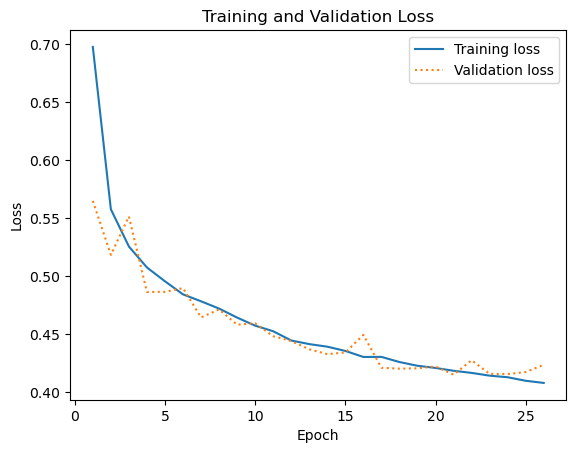

In [126]:
plt.plot(epochs, model_loss, '-', label='Training loss')
plt.plot(epochs, model_val_loss, ':', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.plot()

[]

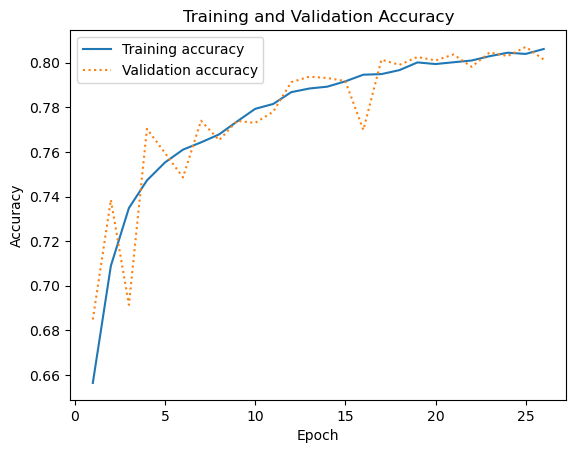

In [127]:
plt.plot(epochs, model_accuracy, '-', label='Training accuracy')
plt.plot(epochs, model_acc_val, ':', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.plot()

In [129]:
y_pred_opt = best_model.predict(X_test)
# Turn the prediction variable into binary
y_pred = (y_pred_opt > 0.5)

932/932 [==============================] - 3s 3ms/step


In [130]:
print('MAE:', mean_absolute_error(y_test, y_pred_opt))  
print('MSE:', mean_squared_error(y_test, y_pred_opt))  
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred_opt)))
print('VarScore:',explained_variance_score(y_test,y_pred_opt))

MAE: 0.27255798747791915
MSE: 0.13254998570775903
RMSE: 0.36407414863975035
VarScore: 0.43480369734653934


Text(50.72222222222221, 0.5, 'Actual')

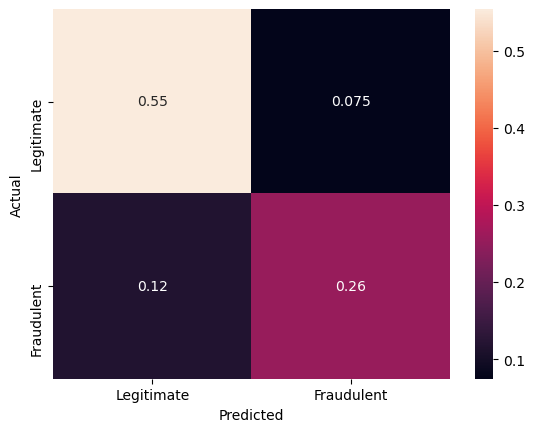

In [131]:
mat = confusion_matrix(y_test, y_pred)
labels_conf_mat = ['Legitimate', 'Fraudulent']
sns.heatmap(mat/np.sum(mat),annot=True, xticklabels=labels_conf_mat, yticklabels=labels_conf_mat)
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [132]:
rf_Recall = recall_score(y_test, y_pred)
rf_Precision = precision_score(y_test, y_pred)
rf_f1 = f1_score(y_test, y_pred)
rf_accuracy = accuracy_score(y_test, y_pred)

In [133]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.88      0.85     18733
           1       0.77      0.69      0.73     11070

    accuracy                           0.81     29803
   macro avg       0.80      0.78      0.79     29803
weighted avg       0.81      0.81      0.81     29803

